In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import RNA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from statannotations.Annotator import Annotator

How is the efficacy of CRISPR-TO effected by read coverage over the guides, off target hits, MFE, and total number of guides in the experiment?
-

In [2]:
#this is the off-target table 
off = pd.read_csv('mengting_guides/off_target_hits.csv',)
off['guide']=off['gRNA name']
off.drop(columns=['gRNA name'],inplace=True)
off['guide'] = off['guide'].str.replace('-','_')
off['gene'] = off['guide'].str.split('_').str[0]
off['guide'] = off['guide'].str.split('_').str[1]
off['guide'] = off['guide'].str.replace('gRNA','')
off['guide'] = off['guide'].astype(int)
off['hits'] = off['higher_threshold_evalue1'].astype(int)
off

,sequence,higher_threshold_evalue1,guide,gene,hits
0,gcagtacataatttacacagaagcaatgct,19,1,Actb,19
1,gtgtgcacttttattggtctcaagtcagtg,7,2,Actb,7
2,gctccaaccaactgctgtcgccttcaccgt,3,3,Actb,3
3,gttttgtcaaagaaagggtgtaaaacgcag,8,4,Actb,8
4,gcctcaacacctcaaccccctcccagggag,8,5,Actb,8
5,gtacaaagtcctcagccacatttgtagaac,8,6,Actb,8
6,gaagcaatgctgtcaccttccccggggtgg,10,7,Actb,10
7,gccctggctgcctcaacacctcaaccccct,14,8,Actb,14
8,gggaggcctcagacctgggccattcagaaa,4,9,Actb,4
9,gtaaccacttatttcatggatacttggaat,11,10,Actb,11


In [3]:
#get the MFE of the guides used 
def calculate_mfe(df):
    df['MFE'] = 0.0
    for i, row in df.iterrows():
        sequence = row['sequence']
        (structure, mfe) = RNA.fold(sequence)
        df.at[i, 'MFE'] = mfe
    return df

off = calculate_mfe(off)
off

,sequence,higher_threshold_evalue1,guide,gene,hits,MFE
0,gcagtacataatttacacagaagcaatgct,19,1,Actb,19,-0.5
1,gtgtgcacttttattggtctcaagtcagtg,7,2,Actb,7,-2.4
2,gctccaaccaactgctgtcgccttcaccgt,3,3,Actb,3,-0.1
3,gttttgtcaaagaaagggtgtaaaacgcag,8,4,Actb,8,-2.3
4,gcctcaacacctcaaccccctcccagggag,8,5,Actb,8,-4.3
5,gtacaaagtcctcagccacatttgtagaac,8,6,Actb,8,-2.8
6,gaagcaatgctgtcaccttccccggggtgg,10,7,Actb,10,-6.9
7,gccctggctgcctcaacacctcaaccccct,14,8,Actb,14,-0.7
8,gggaggcctcagacctgggccattcagaaa,4,9,Actb,4,-9.6
9,gtaaccacttatttcatggatacttggaat,11,10,Actb,11,-2.7


In [4]:
#read in the experimental function table 
func = pd.read_csv('mengting_guides/guide_score_mapping.csv')
func['guide_combo']=func['gRNA combination']
func['score']=func['Rough score']
func['gene']=func['mRNA'].astype(str)
func.drop(columns=['gRNA combination', 'Rough score', 'mRNA'],inplace=True)
func['guide_combo'] = func['guide_combo'].apply(lambda x: list(map(int, x.split(','))))
func

,guide_combo,score,gene
0,"[1, 2, 3, 5, 6, 9, 10]",3,Actb
1,"[2, 3, 5, 6, 9, 10]",2,Actb
2,"[1, 3, 5, 6, 9, 10]",1,Actb
3,"[1, 2, 5, 6, 9, 10]",2,Actb
4,"[1, 2, 3, 6, 9, 10]",4,Actb
5,"[1, 2, 3, 5, 9, 10]",2,Actb
6,"[1, 2, 3, 5, 6, 10]",3,Actb
7,"[1, 2, 3, 5, 6, 9]",3,Actb
8,"[1, 2, 3, 6]",2,Actb
9,"[1, 2, 6]",3,Actb


In [5]:
def get_norm_reads(data_file):
    data = pd.read_csv(data_file, delimiter='\t', header=None)
    data.columns = ['chrom', 'start', 'end', 'guide', 'reads', 'bases_with_coverage', 'length', 'density']
    data['guide'] = data['guide'].str.replace('-','_')
    data['gene'] = data['guide'].str.split('_').str[0]
    data['guide'] = data['guide'].str.split('_').str[1]
    data['guide'] = data['guide'].str.replace('gRNA','')
    data['guide'] = data['guide'].astype(int)
    data['norm_reads'] = data.groupby('gene')['reads'].transform(lambda x: (x-x.min())/(x.max()-x.min()))
    return data 


In [6]:
#for each row in func, take the rows in data that match the gene and sum the norm_reads according to the guide_combo
def add_rep_data_to_func(func, data, off, columns=['norm_reads', 'off_target', 'MFE']):
    read_column = columns[0]
    off_column = columns[1]
    energy_column = columns[2]
    func[read_column] = np.nan
    func[off_column] = np.nan
    func[energy_column] = np.nan
    for i in range(len(func)):
        gene = func.iloc[i]['gene']
        guide_combo = func.iloc[i]['guide_combo']
        norm_reads = data[(data['gene']==gene) & (data['guide'].isin(guide_combo))]['norm_reads'].sum()
        off_target = off[(off['gene']==gene) & (off['guide'].isin(guide_combo))]['hits'].mean()
        energy = off[(off['gene']==gene) & (off['guide'].isin(guide_combo))]['MFE'].mean()
        func.at[i, read_column] = norm_reads
        func.at[i, off_column] = off_target
        func.at[i, energy_column] = energy
    return func

In [8]:
#rep1
func1 = func.copy()
data = get_norm_reads('mengting_guides/Coverage_corticalRNA1_align_Aligned.bed')
func1 = add_rep_data_to_func(func1, data, off, columns=['norm_reads', 'off_target', 'MFE'])
func1['condition']= 'Cortical Neuron RNA: Liter 1'
func1['guide_number'] = func1['guide_combo'].apply(lambda x: len(x))

#rep2 
func2 = func.copy()
data = get_norm_reads('mengting_guides/Coverage_MsCtxRNA2_align_Aligned.bed')
func2 = add_rep_data_to_func(func2, data, off, columns=['norm_reads', 'off_target', 'MFE'])
func2['condition']= 'Cortical Neuron RNA: Liter 2'
func2['guide_number'] = func2['guide_combo'].apply(lambda x: len(x))

#rep 3
func3 = func.copy()
data = get_norm_reads('mengting_guides/Coverage_MsCtxRNA3_align_Aligned.bed')
func3 = add_rep_data_to_func(func3, data, off, columns=['norm_reads', 'off_target', 'MFE'])
func3['condition']= 'Cortical Neuron RNA: Liter 3'
func3['guide_number'] = func3['guide_combo'].apply(lambda x: len(x))

#combine
func_end = pd.concat([func1, func2, func3])
func_end.to_csv('mengting_guides/Data_guide_combinations_experimental_efficiency.csv', index=False)
func_end

,guide_combo,score,gene,norm_reads,off_target,MFE,condition,guide_number
0,"[1, 2, 3, 5, 6, 9, 10]",3,Actb,3.546031,8.571429,-3.200000,Cortical Neuron RNA: Liter 1,7
1,"[2, 3, 5, 6, 9, 10]",2,Actb,2.590462,6.833333,-3.650000,Cortical Neuron RNA: Liter 1,6
2,"[1, 3, 5, 6, 9, 10]",1,Actb,3.546031,8.833333,-3.333333,Cortical Neuron RNA: Liter 1,6
3,"[1, 2, 5, 6, 9, 10]",2,Actb,3.205614,9.500000,-3.716667,Cortical Neuron RNA: Liter 1,6
4,"[1, 2, 3, 6, 9, 10]",4,Actb,3.354845,8.666667,-3.016667,Cortical Neuron RNA: Liter 1,6
...,...,...,...,...,...,...,...,...
42,"[2, 8, 11]",3,Gap43,1.812250,17.666667,-1.100000,Cortical Neuron RNA: Liter 3,3
43,"[2, 11, 15]",3,Gap43,2.559244,8.333333,-2.233333,Cortical Neuron RNA: Liter 3,3
44,"[8, 11, 15]",3,Gap43,1.776760,11.666667,-2.233333,Cortical Neuron RNA: Liter 3,3
45,"[8, 13, 15]",4,Gap43,2.038924,11.666667,-1.666667,Cortical Neuron RNA: Liter 3,3


/Users/jbezney/opt/anaconda3/envs/MIRA/lib/python3.7/site-packages/statannotations/_Plotter.py:338: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  "Invalid x-position found. Are the same parameters passed "
/Users/jbezney/opt/anaconda3/envs/MIRA/lib/python3.7/site-packages/statannotations/_Plotter.py:338: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  "Invalid x-position found. Are the same parameters passed "
/Users/jbezney/opt/anaconda3/envs/MIRA/lib/python3.7/site-packages/statannotations/_Plotter.py:338: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  "Invalid x-position found. Are the same parameters passed "
/Users/jbezney/opt/anaconda3/envs/MIRA/lib/python3.7/site-packages/statannotations/_Plotter.py:338: 

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.168e-06 U_stat=9.600e+01
0 vs. 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.165e-08 U_stat=1.370e+02
0 vs. 3: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.525e-06 U_stat=2.580e+02
0 vs. 4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.750e-05 U_stat=1.800e+01


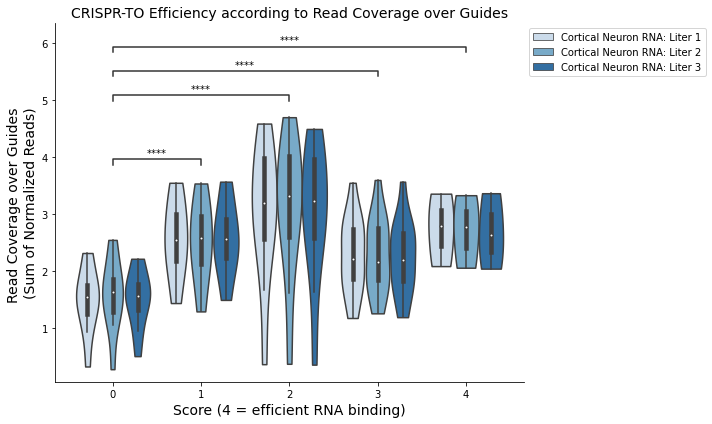

In [9]:
#plot the score 
plt.figure(figsize=(10, 6))
sns.violinplot(x='score', y='norm_reads', data=func_end, cut=0, hue='condition', width=0.85, palette='Blues')
plt.title('CRISPR-TO Efficiency according to Read Coverage over Guides', fontsize=14)
plt.xlabel('Score (4 = efficient RNA binding)', fontsize=14)
plt.ylabel('Read Coverage over Guides \n(Sum of Normalized Reads)', fontsize=14)
sns.despine()
plt.legend(title='', fontsize='10', loc='upper left', bbox_to_anchor=(1, 1))

pairs = [(0, 1), (0, 2), (0, 3), (0, 4)]
annotator = Annotator(plt.gca(), pairs, data=func_end, x='score', y='norm_reads')
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction="BH")
annotator.apply_and_annotate()

plt.tight_layout()
plt.savefig('mengting_guides/rough_score_vs_sum_norm_reads.pdf', dpi=300)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.962e-01 U_stat=4.500e+01
0 vs. 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.961e-01 U_stat=8.750e+01
0 vs. 3: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.392e-01 U_stat=9.900e+01
0 vs. 4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.253e-01 U_stat=2.500e+01


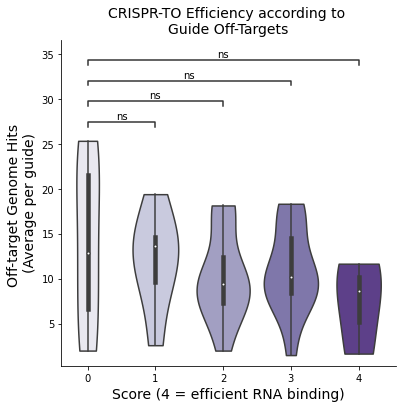

In [10]:
#the off target is dependant on the guides whcih is the same for every eximperiment, so no replicates for this data
plt.figure(figsize=(6, 6))
sns.violinplot(x='score', y='off_target', data=func1, cut=0 , width=0.8, palette='Purples')
plt.title('CRISPR-TO Efficiency according to \nGuide Off-Targets', fontsize=14)
plt.xlabel('Score (4 = efficient RNA binding)', fontsize=14)
plt.ylabel('Off-target Genome Hits \n(Average per guide)', fontsize=14)
sns.despine()
plt.legend().remove()

pairs = [(0, 1), (0, 2), (0, 3), (0, 4)]
annotator = Annotator(plt.gca(), pairs, data=func1, x='score', y='off_target')
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction="BH")
annotator.apply_and_annotate()

plt.savefig('mengting_guides/rough_score_vs_sum_off_target_hits.pdf', dpi=300)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.278e-01 U_stat=3.700e+01
0 vs. 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.224e-01 U_stat=7.450e+01
0 vs. 3: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.782e-01 U_stat=7.800e+01
0 vs. 4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.593e-01 U_stat=2.000e+01


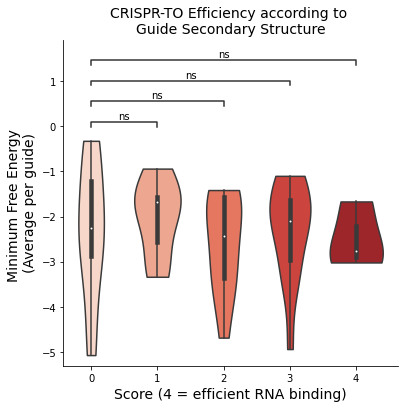

In [11]:
#the off target is dependant on the guides whcih is the same for every eximperiment
plt.figure(figsize=(6, 6))
sns.violinplot(x='score', y='MFE', data=func1, cut=0, width=0.8, palette='Reds')
plt.title('CRISPR-TO Efficiency according to \nGuide Secondary Structure', fontsize=14)
plt.xlabel('Score (4 = efficient RNA binding)', fontsize=14)
plt.ylabel('Minimum Free Energy \n(Average per guide)', fontsize=14)
sns.despine()
plt.legend().remove()

pairs = [(0, 1), (0, 2), (0, 3), (0, 4)]
annotator = Annotator(plt.gca(), pairs, x='score', y='MFE', data=func1,)
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction="BH")
annotator.apply_and_annotate()

plt.savefig('mengting_guides/rough_score_vs_mean_MFE_guides.pdf', dpi=300)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.906e-02 U_stat=2.000e+01
0 vs. 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.417e-03 U_stat=1.500e+01
0 vs. 3: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.033e-01 U_stat=5.550e+01
0 vs. 4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.856e-01 U_stat=1.300e+01


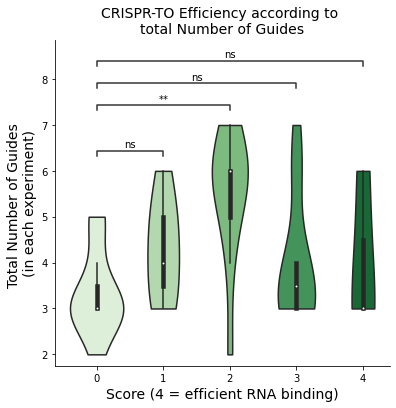

In [12]:
#plot the relationship of the total number of guides and the score 
plt.figure(figsize=(6, 6))
sns.violinplot(x='score', y='guide_number', data=func1, cut=0, width=0.8, palette='Greens')
plt.title('CRISPR-TO Efficiency according to \ntotal Number of Guides', fontsize=14)
plt.xlabel('Score (4 = efficient RNA binding)', fontsize=14)
plt.ylabel('Total Number of Guides \n(in each experiment)', fontsize=14)
sns.despine()
plt.legend().remove()

pairs = [(0, 1), (0, 2), (0, 3), (0, 4)]
annotator = Annotator(plt.gca(), pairs, x='score', y='guide_number', data=func1,)
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction="BH")
annotator.apply_and_annotate()

plt.savefig('mengting_guides/rough_score_vs_guide_number_guides.pdf', dpi=300)
plt.show()

Standardized Coefficients (relative importance):
norm_reads: 0.49481021440658307
MFE: 0.2739861620478423
off-target: -0.44330479998640016
guide_number: -0.20763648595796058

Permutation Feature Importance:
        feature  importance_mean  importance_std
0    norm_reads         0.303810        0.059247
2    off_target         0.231715        0.054562
1           MFE         0.096179        0.032060
3  guide_number         0.054995        0.022565


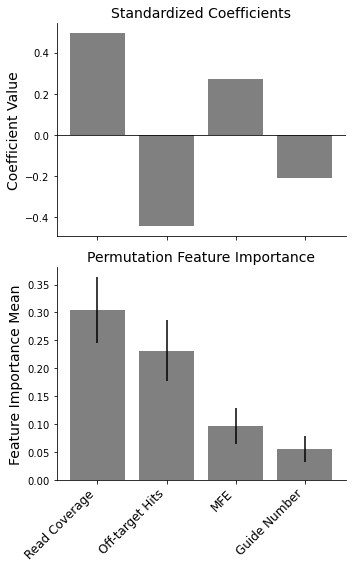

In [14]:
#run linear regression and feature importance 
X = func_end[['norm_reads', 'MFE', 'off_target', 'guide_number']]
y = func_end['score']

# Standardize the predictor variables and fit 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
model = LinearRegression()
model.fit(X_scaled, y)

# Get the standardized coefficients, since they are z-scored the coefficients are the relative importance of each feature
standardized_weights = model.coef_
print("Standardized Coefficients (relative importance):")
print(f"norm_reads: {standardized_weights[0]}")
print(f"MFE: {standardized_weights[1]}")
print(f"off-target: {standardized_weights[2]}")
print(f"guide_number: {standardized_weights[3]}\n")

# Perform permutation importance just to confirm 
perm_importance = permutation_importance(model, X_scaled, y, n_repeats=30, random_state=0)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
})

print("Permutation Feature Importance:")
print(importance_df.sort_values(by='importance_mean', ascending=False))
importance_df_sorted = importance_df.sort_values(by='importance_mean', ascending=False)

# Rearrange the coefficients to match the sorted features
sorted_coefficients = [standardized_weights[X.columns.get_loc(feature)] for feature in importance_df_sorted['feature']]
importance_df_sorted['feature'] = ['Read Coverage', 'Off-target Hits', 'MFE', 'Guide Number']

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(5, 8), sharex=True)
axs[0].bar(importance_df_sorted['feature'], sorted_coefficients, color='grey')
axs[0].set_title('Standardized Coefficients', fontsize=14)
axs[0].set_ylabel('Coefficient Value', fontsize=14)
axs[0].axhline(0, color='black', linewidth=0.8)

axs[1].bar(importance_df_sorted['feature'], importance_df_sorted['importance_mean'], yerr=importance_df_sorted['importance_std'], color='grey')
axs[1].set_title('Permutation Feature Importance', fontsize=14)
axs[1].set_xlabel('')
axs[1].set_ylabel('Feature Importance Mean', fontsize=14)
sns.despine()
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.savefig('mengting_guides/feature_importance.pdf', dpi=300)
plt.show()